In [124]:
import imutils
import face_recognition
import argparse
import pickle
import cv2
import os
import time
import IPython.display
import matplotlib.pyplot as plt
import tensorflow as tf
from align import detect_face
import numpy as np

In [128]:
dataset = "simpledataset"
encodings_file = "data/encodings.{}.pickle"
detection_method = "cnn"

In [177]:
def find_faces(imagePaths, module = 'face_recognition', detection_method = 'cnn'):    
    if module == 'face_recognition':
        print("[INFO] started with {} method {}".format(module, detection_method))
    elif module == 'opencv':  
        print("[INFO] started with {}".format(module))
    elif module == 'facenet':    
        print("[INFO] started with {}".format(module))
        sess = tf.Session()
        # read pnet, rnet, onet models from align directory and files are det1.npy, det2.npy, det3.npy
        pnet, rnet, onet = detect_face.create_mtcnn(sess, 'align')
        
    # initialize the list of known encodings and known names
    knownBoxes = []
    knownNames = []

    if module == 'opencv':
        face_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')
    
    # loop over the image paths
    for (i, imagePath) in enumerate(imagePaths):
        # extract the person name from the image path
        print("[INFO] processing image {}/{}".format(i + 1, len(imagePaths)))
        name = imagePath.split(os.path.sep)[-2]

        # load the input image and convert it from BGR (OpenCV ordering)
        # to dlib ordering (RGB)
        image = cv2.imread(imagePath)
        if module == 'face_recognition':
            image_recolor = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif module == 'opencv':    
            image_recolor = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        elif module == 'facenet':    
            image_recolor = image

        if module == 'face_recognition':
            # detect the (x, y)-coordinates of the bounding boxes
            # corresponding to each face in the input image
            boxes = face_recognition.face_locations(image_recolor, model=detection_method)
        elif module == 'opencv':
            boxes = face_cascade.detectMultiScale(image_recolor, 1.3, 6)
        elif module == 'facenet':    
            minsize = 20
            threshold = [0.6, 0.7, 0.7]
            factor = 0.709
            margin = 44

            def getFace(img):
                bxs = []
                img_size = np.asarray(img.shape)[0:2]
                bounding_boxes, _ = detect_face.detect_face(img, minsize, pnet, rnet, onet, threshold, factor)
                if not len(bounding_boxes) == 0:
                    for face in bounding_boxes:
                        if face[4] > 0.50:
                            det = np.squeeze(face[0:4])
                            bb = np.zeros(4, dtype=np.int32)
                            bb[0] = np.maximum(det[0] - margin / 2, 0)
                            bb[1] = np.maximum(det[1] - margin / 2, 0)
                            bb[2] = np.minimum(det[2] + margin / 2, img_size[1])
                            bb[3] = np.minimum(det[3] + margin / 2, img_size[0])
                            bxs.append(([bb[0], bb[1], bb[2], bb[3]]))
                return bxs
            boxes = getFace(image_recolor)

        # loop over the boxes
        #for encoding in encodings:
        for box in boxes:
            # add each encoding + name to our set of known names and
            # encodings
            knownBoxes.append(box)
            knownNames.append(name)
    return {"boxes": knownBoxes, "names": knownNames}

In [178]:
imagePaths = list(imutils.paths.list_images(dataset))

In [179]:
start_time = time.time()
result_fn = find_faces(imagePaths, 'facenet')
print("[INFO] --- %s seconds --- " % (time.time() - start_time))

[INFO] started with facenet


ValueError: Variable pnet/conv1/weights already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)


In [147]:
start_time = time.time()
result_fr_cnn = find_faces(imagePaths, 'face_recognition', 'cnn')
print("[INFO] --- %s seconds --- " % (time.time() - start_time))

[INFO] started with face_recognition method cnn
[INFO] processing image 1/1
[INFO] --- 11.047136545181274 seconds --- 


In [148]:
start_time = time.time()
result_fr_hog = find_faces(imagePaths, 'face_recognition', 'hog')
print("[INFO] --- %s seconds --- " % (time.time() - start_time))

[INFO] started with face_recognition method hog
[INFO] processing image 1/1
[INFO] --- 0.09362006187438965 seconds --- 


In [167]:
start_time = time.time()
result_cv = find_faces(imagePaths, 'opencv')
print("[INFO] --- %s seconds --- " % (time.time() - start_time))

[INFO] started with opencv
[INFO] processing image 1/1
[INFO] --- 0.04680371284484863 seconds --- 


In [175]:
def draw_image_information(image, name, data, label, color):
    boxes = [data['boxes'][i] for i, v in enumerate(data['names']) if v == name]
    for (top, right, bottom, left) in boxes:
        if label == "facenet":
            cv2.rectangle(image, (top, right), (bottom, left), color, 2)
            y = bottom - 15 if bottom - 15 > 15 else bottom + 15
            cv2.putText(image, label, (right, y), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)            
        else:    
            cv2.rectangle(image, (left, top), (right, bottom), color, 2)
            y = top - 15 if top - 15 > 15 else top + 15
            cv2.putText(image, label, (left, y), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)            
    return image

(59, 213, 229, 43)
(98, 218, 253, 64)
(33, 58, 215, 215)


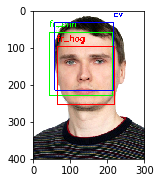

In [176]:
# loop over the image paths
IPython.display.clear_output(wait=True)
plt.figure(figsize=(14, 6))
for (i, imagePath) in enumerate(imagePaths):
    # extract the person name from the image path
    name = imagePath.split(os.path.sep)[-2]
    
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    draw_image_information(image, name, result_fr_cnn, "fr_cnn", (0, 255, 0))
    draw_image_information(image, name, result_fr_hog, "fr_hog", (255, 0, 0))
    draw_image_information(image, name, result_cv, "cv", (0, 0, 255))         
        
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)

In [143]:
# dump the facial encodings + names to disk
print("[INFO] serializing encodings...")
f = open(encodings_file.format("result_fr_cnn"), "wb")
f.write(pickle.dumps(result_fr_cnn))
f.close()

f = open(encodings_file.format("result_fr_hog"), "wb")
f.write(pickle.dumps(result_fr_hog))
f.close()

f = open(encodings_file.format("result_cv"), "wb")
f.write(pickle.dumps(result_cv))
f.close()

[INFO] serializing encodings...
